In [11]:
%matplotlib inline

import numpy as np
#from Feature_Extraction import *
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import spearmanr
from Bio.SeqUtils import MeltingTemp as mt
import matplotlib.pyplot as plt


FILE = open("Figure1b/Cross_Validation_Example_Code/Hyperparameter_Candidates_BoostedRT.txt", "r")
Models = FILE.readlines()
FILE.close()

In [12]:
def Feature_Extraction(lines):
    lines = list(lines)
    data_n = len(lines)
    DATA_X = np.zeros((data_n,34,4), dtype=int)
    DATA_Y = np.zeros((data_n,), dtype=float)
    energy = np.zeros((data_n,), dtype=float)
    SEQ = []
    
    for l in range(data_n):
        data = lines[l].split()
        seq = data[0]
        SEQ.append(seq)
        for i in range(34):
            if seq[i] in "Aa":   DATA_X[l, i, 0] = 1
            elif seq[i] in "Cc": DATA_X[l, i, 1] = 1
            elif seq[i] in "Gg": DATA_X[l, i, 2] = 1
            elif seq[i] in "Tt": DATA_X[l, i, 3] = 1
        DATA_Y[l] = float(data[1])
        energy[l] = float(data[2])
    
    #Feature Extraction
    DATA_X_FE = np.zeros((data_n,689), dtype=float)
    for l in range(data_n):
        #position-independent nucleotides and dinucleotides (4 + 4^2 = 20)
        for i in range(4):
            DATA_X_FE[l,i] = sum(DATA_X[l,:,i])
        for i in range(4,20):
            DATA_X_FE[l,i] = Dinucleotide_FE(DATA_X[l], int((i-4)/4), int((i-4)%4))
            
        #position-dependent nucleotides and dinucleotides ( 4*34 + (4^2 * 33) = 664)
        for i in range(20, 156):
            DATA_X_FE[l,i] = DATA_X[l, int((i-20)/4), int((i-20)%4)]
        for i in range(156,684):
            DATA_X_FE[l,i] = Dinucleotide_FE(DATA_X[l, int((i-156)/16):int((i-156)/16+2), :], int(((i-156)%16)/4), int(((i-156)%16)%4))
            
        #Melting temperatiure (1)
        DATA_X_FE[l,684] = mt.Tm_NN(SEQ[l])
           
        #GC count (3)
        DATA_X_FE[l,685] = SEQ[l].count("G") + SEQ[l].count("g") + SEQ[l].count("C") + SEQ[l].count("c")
        if DATA_X_FE[l,685] <= 9:
            DATA_X_FE[l,686] = 1
            DATA_X_FE[l,687] = 0
        else:
            DATA_X_FE[l,686] = 0
            DATA_X_FE[l,687] = 1
            
        #Free energy
        #DATA_X_FE[l,688] = RNA.fold(SEQ[l])[1]
        DATA_X_FE[l,688] = energy[l]

    return DATA_X_FE, DATA_Y

def Dinucleotide_FE(X, a, b):
    num = 0
    for i in range(X.shape[0]-1):
        if X[i,a] == 1 and X[i+1,b] == 1:
            num += 1
    return num

In [21]:
import random

IDX = [500, 1000, 2000, 4000, 8000, 13500]
#IDX = [50, 100]

innerFolds = 2
outerFolds = 2

#split training data
def split_data(rand=False):
    infile = open("Figure1b/training_energy.txt", "r")
    data = infile.readlines()[1:]
    infile.close()
    
    if rand:
        random.shuffle(data)
    
    valdata = np.array(data[:1500])
    data = np.array(data[1500:])
    
    for idx in range(len(IDX)):
        for f in range(outerFolds):
            
            n = int(len(valdata)/outerFolds)
            valind = range(f*n, f*n+n)
            trainind = [x for x in range(len(valdata)) if x not in valind]
            
            file = open("DATA/%s_NestedCV_OuterFold%d_Validation.txt" % (idx, f), "w")
            file.write("".join(valdata[valind]))
            file.close()
            
            file = open("DATA/%s_NestedCV_OuterFold%d_Train.txt" % (idx, f), "w")
            file.write("".join(valdata[trainind]))
            file.close()
            
            for i in range(innerFolds):
                part = data[:IDX[idx]]
                
                n = int(len(part)/innerFolds)
                valind = range(i*n, i*n+n)
                trainind = [x for x in range(len(part)) if x not in valind]
                
                file = open("DATA/%s_NestedCV_OuterFold%d_InnerFold%d_Validation.txt" % (idx, f, i), "w")
                file.write("".join(part[valind]))
                file.close()

                file = open("DATA/%s_NestedCV_OuterFold%d_InnerFold%d_Train.txt" % (idx, f, i), "w")
                file.write("".join(part[trainind]))
                file.close()


split_data(True)

In [22]:
# -----------------------------------------------------
# Nested Cross-validation
# -----------------------------------------------------

all_Results = []
for idx in range(len(IDX)):

    NestedCV_Results = []
    # Outer 10-fold CV
    for f in range(outerFolds):
        
        Model_Selection_Results = [0.0] * len(Models)
        # Inner 5-fold CV
        for i in range(innerFolds):
            # Load inner CV training data
            FILE = open("DATA/%s_NestedCV_OuterFold%d_InnerFold%d_Train.txt" % (idx, f, i), "r")
            data = FILE.readlines()
            TRAIN_DATA_X, TRAIN_DATA_Y = Feature_Extraction(data)
            FILE.close()

            # Load inner CV validation data
            FILE = open("DATA/%s_NestedCV_OuterFold%d_InnerFold%d_Validation.txt" % (idx, f, i), "r")
            data = FILE.readlines()
            VAL_DATA_X, VAL_DATA_Y = Feature_Extraction(data)
            FILE.close()
                
            # Model hyperparameter selection
            for m in range(len(Models)):   
                Tokens = Models[m].strip().split()
                model = GradientBoostingRegressor(n_estimators = int(Tokens[0]), max_depth = int(Tokens[1]), min_samples_split = int(Tokens[2]), min_samples_leaf = int(Tokens[3]), max_features = Tokens[4])
                
                # Training
                model.fit(TRAIN_DATA_X, TRAIN_DATA_Y) 

                # Validation
                val_result = spearmanr(VAL_DATA_Y, model.predict(VAL_DATA_X))[0]
                Model_Selection_Results[m] += val_result
            
            
        # Select best performing model from inner 5-fold CV     
        Best_Model = np.argmax(Model_Selection_Results)
        Tokens = Models[int(Best_Model)].strip().split()
        model = GradientBoostingRegressor(n_estimators = int(Tokens[0]), max_depth = int(Tokens[1]), min_samples_split = int(Tokens[2]), min_samples_leaf = int(Tokens[3]), max_features = Tokens[4])

        # Load outer CV training data
        FILE = open("DATA/%s_NestedCV_OuterFold%d_Train.txt" % (idx, f), "r")
        data = FILE.readlines()
        TRAIN_DATA_X, TRAIN_DATA_Y = Feature_Extraction(data)
        FILE.close()

        # Load outer CV validation data
        FILE = open("DATA/%s_NestedCV_OuterFold%d_Validation.txt" % (idx, f), "r")
        data = FILE.readlines()
        VAL_DATA_X, VAL_DATA_Y = Feature_Extraction(data)
        FILE.close()
                
        # Training
        model.fit(TRAIN_DATA_X, TRAIN_DATA_Y) 

        # Validation
        val_result = spearmanr(VAL_DATA_Y, model.predict(VAL_DATA_X))[0]
        NestedCV_Results.append(val_result)
        
    all_Results.append(NestedCV_Results)
    print(idx, np.average(NestedCV_Results))

0 0.6534369343902733


1 0.6796905635881443


2 0.6873795391781562


3 0.684154188315659


4 0.6823705841777689


5 0.6644770497698953


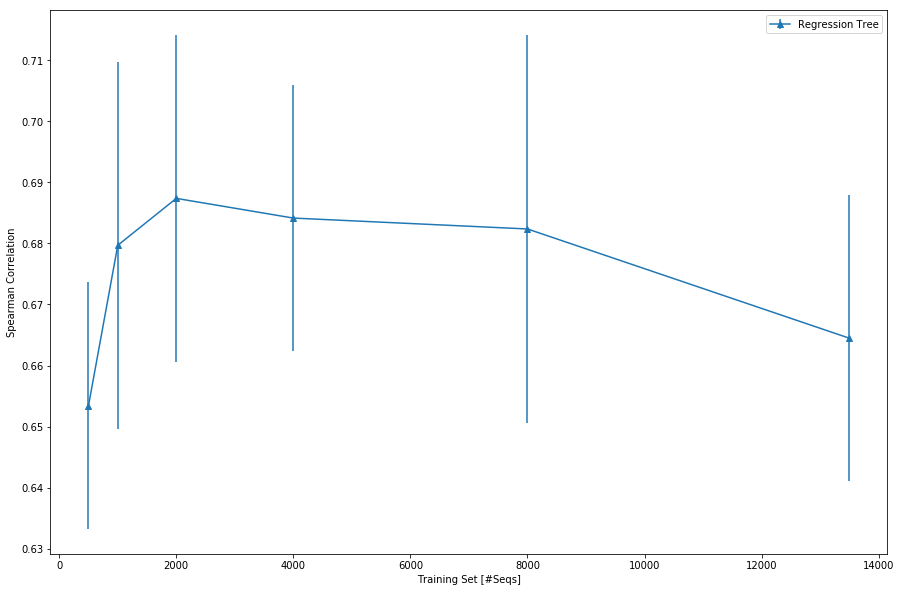

In [23]:
plt.rcParams["figure.figsize"] = (15, 10)

plt.errorbar(IDX, np.mean(all_Results, axis=1), yerr=np.std(all_Results, axis=1), marker='^', label="Regression Tree")

plt.ylabel("Spearman Correlation")
plt.xlabel("Training Set [#Seqs]")
plt.legend()

plt.show()